In [ ]:
!git clone https://github.com/blanchefort/utils.git
!pip install transformers

Cloning into 'utils'...
fatal: could not read Username for 'https://github.com': No such device or address
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 40.0 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 45.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install -U sentence-transformers
!pip install pymorphy2
!pip install morph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 1.2 MB 10.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=28c92bab3e3d89ea1785ae96fdac1b42a7aab65b379dde9c3fa77b43f4cbec14
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 8.2 MB 10.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for morph: filename=morph-0.1.5-py3-none-any.whl size=22481 sha256=757c29d599e1210b54136d2d3d24cd8aa8ecaf941887b3b2b06a4b469319a5a

In [ ]:
import numpy as np
import pandas as pd
from random import randint
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from keras.preprocessing.sequence import pad_sequences

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = pd.read_csv('ru_with_my_part.csv')
df

,Unnamed: 0,Unnamed: 0.1,Russian_text,Emotion,Emotion_id
0,19736,3096.0,"«мне не стыдно за это», возразила она, напряж...",anger,3
1,2738,6577.0,все еще болен!!! в основном спал в ванной! и я...,sadness,1
2,13132,3255.0,Полузащитник сборной России Алан Дзагоев восст...,neutral,5
3,9575,5166.0,"Воот, а Танюшка удивляется)))",joy,0
4,1938,6121.0,"Я не впадал в депрессию, но то, как атаковали ...",sadness,1
...,...,...,...,...,...
26418,14507,NaN,"«Это невероятно, я согласен», — ответил Говард...",shame,7
26419,7806,5714.0,парад в честь дня благодарения macy's начался!...,joy,0
26420,21574,7703.0,"когда я нахожу моменты, чтобы полюбить птиц у ...",joy,0
26421,12353,7949.0,"А грехи у всех одни и те же : гордость , сребр...",neutral,5


In [ ]:
df.sample(5)

,Unnamed: 0,Unnamed: 0.1,Russian_text,Emotion,Emotion_id
25325,16991,NaN,"ей было немного стыдно, что это доставило ей т...",shame,7
19967,20313,8605.0,"В комментариях к видеозаписи Бодров сообщил, ч...",neutral,5
24364,20027,17920.0,""": tu n'irais pas à orléans par hasard? "" // j...",fear,2
9863,13346,12062.0,"коротко, редко, плохо, #dumpit. # страх это уж...",anger,3
9840,12521,16302.0,я ненавижу это!. так всегда бывает !. все отме...,anger,3


In [ ]:
df.Emotion.unique()

array(['anger', 'sadness', 'neutral', 'joy', 'surprise', 'shame',
       'disgust', 'fear'], dtype=object)

In [ ]:
# Присвоим каждой категории индекс, чтобы подавать в модель
category_index = {i[1]:i[0] for i in enumerate(df.Emotion.unique())}
# обратное преобразование - индекс метки в текст, этот словарь нам понадобится 
# после обучения для большей наглядности, чтобы видеть, к какой эмоции текст 
# отнесён моделью
category_index_reverce = {i[0]:i[1] for i in enumerate(df.Emotion.unique())}

In [ ]:
category_index_reverce

{0: 'anger',
 1: 'sadness',
 2: 'neutral',
 3: 'joy',
 4: 'surprise',
 5: 'shame',
 6: 'disgust',
 7: 'fear'}

In [ ]:
category_index

{'anger': 0,
 'disgust': 6,
 'fear': 7,
 'joy': 3,
 'neutral': 2,
 'sadness': 1,
 'shame': 5,
 'surprise': 4}

In [ ]:
sentences = df.Russian_text.values
labels = [category_index[i] for i in df.Emotion.values]

In [ ]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [ ]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.1)

In [ ]:
len(train_sentences), len(test_sentences)

(23780, 2643)

In [ ]:
pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 4.8 MB/s 
     |████████████████████████████████| 132 kB 59.2 MB/s 
     |████████████████████████████████| 880 kB 62.8 MB/s 
     |████████████████████████████████| 8.8 MB 45.3 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 138 kB 57.8 MB/s 
     |████████████████████████████████| 127 kB 48.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=09503419f5b0d7a6e272215693c564fe929e81f35358d8323f843bcab4cc62f3
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not 

In [ ]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'DeepPavlov/rubert-base-cased')

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/main.zip" to /root/.cache/torch/hub/main.zip


Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

In [ ]:
print(tokenized_texts[42])

['[CLS]', ',', 'только', 'начал', 'печь', '.', 'бь', '##юсь', 'об', 'заклад', ',', 'вы', 'не', 'можете', 'догад', '##аться', ',', 'что', 'я', 'делаю', 'на', 'завтра', '.', '[SEP]']


In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

(array([1.7227e+04, 6.3550e+03, 1.7400e+02, 1.8000e+01, 5.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  4. ,  28.8,  53.6,  78.4, 103.2, 128. , 152.8, 177.6, 202.4,
        227.2, 252. ]),
 <a list of 10 Patch objects>)

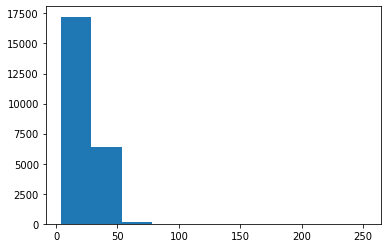

In [ ]:
# Соберём все размеры последовательностей
lenths = [len(sent) for sent in tokenized_texts]
# Посмотрим, как они распределяются
plt.hist(lenths)

In [ ]:
input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=60,
    dtype='long',
    truncating='post',
    padding='post'
)

In [ ]:
input_ids[42]

array([   101,    128,   4564,   4051,  62149,    132,  54153,  29627,
         1650,  31783,    128,   1761,   1699,  54119,  46366,   4563,
          128,   1997,    877, 109050,   1469,  41563,    132,    102,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0])

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
print(attention_masks[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
assert len(input_ids[42]) == len(attention_masks[42])

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category, 
    random_state=42,
    test_size=0.3
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.3
)

In [ ]:
assert len(train_inputs) == len(train_labels) == len(train_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_masks)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import Sampler, SequentialSampler

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=16
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16
)

In [ ]:
config = AutoConfig.from_pretrained('DeepPavlov/rubert-base-cased',
                                    num_labels=len(category_index),
                                    id2label=category_index_reverce,
                                    label2id=category_index)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', config = config)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
param_optimizer = list(model.named_parameters())

In [ ]:

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
%%time
train_loss_set = []
train_loss = 0

# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Обнуляем градиенты
    optimizer.zero_grad()
    
    # Прогоняем данные по слоям нейросети
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Обратный прогон
    loss[0].backward()
    
    # Шаг
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss / len(train_dataloader)}')

Loss: 2.1065480709075928
Loss: 2.0795469284057617
Loss: 2.122375726699829
Loss: 2.0172455310821533
Loss: 2.0180861949920654
Loss: 2.0198168754577637
Loss: 2.0173163414001465
Loss: 2.0271944999694824
Loss: 1.8797805309295654
Loss: 2.0042190551757812
Loss: 1.9226394891738892
Loss: 1.8588508367538452
Loss: 1.9290766716003418
Loss: 2.066697597503662
Loss: 1.916869044303894
Loss: 1.9384299516677856
Loss: 2.066122531890869
Loss: 2.083622694015503
Loss: 1.8120646476745605
Loss: 1.9236358404159546
Loss: 1.90516197681427
Loss: 1.9892733097076416
Loss: 1.8550629615783691
Loss: 2.0444416999816895
Loss: 2.094749689102173
Loss: 2.044167995452881
Loss: 1.812196135520935
Loss: 2.032764196395874
Loss: 1.7431468963623047
Loss: 1.8786934614181519
Loss: 1.906489372253418
Loss: 1.8054507970809937
Loss: 1.9867498874664307
Loss: 1.8624204397201538
Loss: 1.7743319272994995
Loss: 1.788725733757019
Loss: 1.825182318687439
Loss: 1.9231575727462769
Loss: 1.8326301574707031
Loss: 1.833909511566162
Loss: 1.8716099

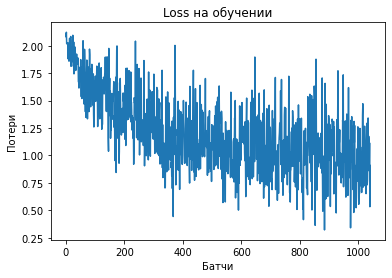

In [ ]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set)
plt.title("Loss на обучении")
plt.xlabel("Батчи")
plt.ylabel("Потери")
plt.show()

In [ ]:
%time

# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    
    
    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print(classification_report(valid_labels, valid_preds, target_names=category_index_reverce.values()))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
              precision    recall  f1-score   support

       anger       0.68      0.57      0.62      1113
     sadness       0.80      0.58      0.67      1084
     neutral       0.82      0.86      0.84      1093
         joy       0.61      0.70      0.65      1091
    surprise       0.48      0.70      0.57      1035
       shame       0.94      0.90      0.92       178
     disgust       0.56      0.45      0.50       437
        fear       0.71      0.63      0.67      1103

    accuracy                           0.66      7134
   macro avg       0.70      0.67      0.68      7134
weighted avg       0.68      0.66      0.67      7134



Сохранение модели

In [ ]:
import pickle
filename = 'second_model.sav'
pickle.dump(model, open(filename, 'wb'))